In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


In [ ]:
import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle


In [ ]:
annotation_folder='/annotations/'
if not os.path.exists(os.path.abspath('.')+annotation_folder):
  annotation_zip=tf.keras.utils.get_file('captions.zip',cache_subdir=os.path.abspath('.'),origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',extract=True)
  annoation_file=os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

In [ ]:
annoation_file

'/content/annotations/captions_train2014.json'

In [ ]:
image_folder='/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip=tf.keras.utils.get_file('train2014.zip',cache_subdir=os.path.abspath('.'),origin='http://images.cocodataset.org/zips/train2014.zip',extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH=os.path.abspath('.')+image_folder

In [ ]:
PATH

'/content/train2014/'

In [ ]:
os.path.abspath('.')

'/content'

In [ ]:
with open(annoation_file,'r') as f:
  annotations=json.load(f)

In [ ]:
image_path_to_caption=collections.defaultdict(list)


In [ ]:
for val in annotations['annotations']:
  caption=f"<start>{val['caption']} <end>"
  image_path=PATH+'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)   

In [ ]:
image_paths=list(image_path_to_caption.keys())
random.shuffle(image_paths)

In [ ]:
train_image_paths=image_paths[:6000]

In [ ]:
print(len(train_image_paths))

6000


In [ ]:
train_image_paths[0]

'/content/train2014/COCO_train2014_000000504988.jpg'

In [ ]:
train_captions=[]
img_name_vector=[]
for image_path in train_image_paths:
  caption_list=image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path]*len(caption_list))

<start>Three men in uniform putting food on the plate. <end>


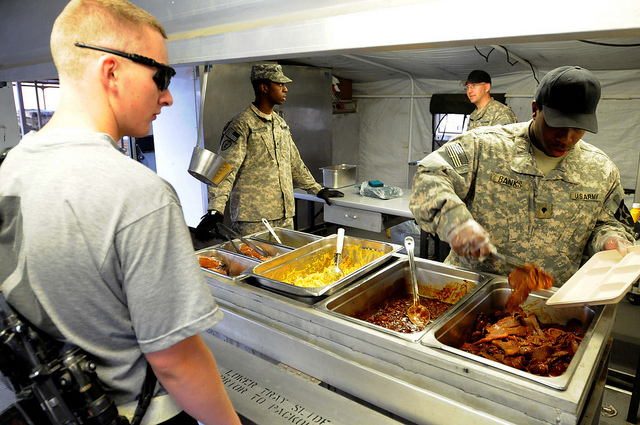

In [ ]:
print(train_captions[0])
Image.open(img_name_vector[0])

In [ ]:
train_captions[:10]

['<start>Three men in uniform putting food on the plate. <end>',
 '<start>A military mess hall with food being dished out. <end>',
 '<start>The mess hall tent of an army operation <end>',
 '<start>The service man is putting meat on the tray. <end>',
 '<start>Military men with U.S. Army uniforms serving food onto trays. <end>',
 '<start>a man on top of a horse herding sheep in a farmland area. <end>',
 '<start>A heard of small ship are being gathered by two horses. <end>',
 '<start>There are horses and many sheep on a farm. <end>',
 '<start>a man on a horse and some sheep and other horses <end>',
 '<start>a farmer on a horse rounding up some sheep <end>']

In [ ]:
img_name_vector[:10]

['/content/train2014/COCO_train2014_000000504988.jpg',
 '/content/train2014/COCO_train2014_000000504988.jpg',
 '/content/train2014/COCO_train2014_000000504988.jpg',
 '/content/train2014/COCO_train2014_000000504988.jpg',
 '/content/train2014/COCO_train2014_000000504988.jpg',
 '/content/train2014/COCO_train2014_000000397325.jpg',
 '/content/train2014/COCO_train2014_000000397325.jpg',
 '/content/train2014/COCO_train2014_000000397325.jpg',
 '/content/train2014/COCO_train2014_000000397325.jpg',
 '/content/train2014/COCO_train2014_000000397325.jpg']

In [ ]:
def load_image(image_path):
  img=tf.io.read_file(image_path)
  img=tf.image.decode_jpeg(img,channels=3)
  img=tf.image.resize(img,(299,299))
  img=tf.keras.applications.inception_v3.preprocess_input(img)
  return img,image_path

In [ ]:
image_model=tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
new_input=image_model.input
hidden_layer=image_model.layers[-1].output
image_features_extract_model=tf.keras.Model(new_input,hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
encode_train=sorted(set(img_name_vector))

In [ ]:
len(encode_train)

6000

In [ ]:
encode_train[:300]

In [ ]:
len(img_name_vector)

30014

In [ ]:
image_dataset=tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset=image_dataset.map(load_image,num_parallel_calls=tf.data.AUTOTUNE).batch(16)

In [ ]:
for img,path in image_dataset:
  batch_features=image_features_extract_model(img)
  batch_features=tf.reshape(batch_features,(batch_features.shape[0],-1,batch_features.shape[3]))
  for bf ,p in zip(batch_features,path):
    path_of_feature=p.numpy().decode("utf-8")
    np.save(path_of_feature,bf.numpy())

In [ ]:
batch_features[0]

<tf.Tensor: shape=(64, 2048), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , ..., 0.681547  , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.9455636 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.5731564 , ..., 1.5155776 , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.8446393 , 0.        ,
        0.        ],
       [0.        , 0.38512975, 0.        , ..., 1.5294152 , 0.        ,
        0.        ],
       [0.        , 0.11229713, 0.        , ..., 1.633241  , 0.        ,
        0.        ]], dtype=float32)>

In [ ]:
path_of_feature

'/content/train2014/COCO_train2014_000000581821.jpg'

In [ ]:
bf

<tf.Tensor: shape=(64, 2048), dtype=float32, numpy=
array([[0.        , 0.        , 0.14933239, ..., 0.26767534, 0.        ,
        0.        ],
       [0.1379337 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.23572801, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.2210911 , 0.        ,
        0.        ],
       [0.18592533, 0.        , 0.        , ..., 0.22466803, 0.        ,
        0.        ]], dtype=float32)>

In [ ]:
def calc_max_length(tensor):
  return max(len(t) for t in tensor)

In [ ]:
top_k=5000
tokenizer=tf.keras.preprocessing.text.Tokenizer(num_words=top_k,oov_token="<unk",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [ ]:
tokenizer.word_index['<pad>']=0
tokenizer.index_word[0]='<pad>'

In [ ]:
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
cap_vector=tf.keras.preprocessing.sequence.pad_sequences(train_seqs,padding='post')

In [ ]:
max_length = calc_max_length(train_seqs)

In [ ]:
max_length

48

In [ ]:
img_to_cap_vector=collections.defaultdict(list)
for img,cap in zip(img_name_vector,cap_vector):
  img_to_cap_vector[img].append(cap)
  

In [ ]:
img_keys=list(img_to_cap_vector.keys())
random.shuffle(img_keys)

In [ ]:
slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

In [ ]:
img_to_cap_vector

In [ ]:
img_name_train_keys

In [ ]:
slice_index

4800

In [ ]:
img_name_train=[]
cap_train=[]
for imgt in img_name_train_keys:
  capt_len=len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt]*capt_len)
  cap_train.extend(img_to_cap_vector[imgt])


In [ ]:
capt_len

5

In [ ]:
imgt

'/content/train2014/COCO_train2014_000000559652.jpg'

In [ ]:
img_to_cap_vector

In [ ]:
img_name_train[-2:]

['/content/train2014/COCO_train2014_000000559652.jpg',
 '/content/train2014/COCO_train2014_000000559652.jpg']

In [ ]:
cap_train[-2:]

[array([  4,  12,   9, 251, 416,  79,   7,   3, 239,   2,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32),
 array([  4,  12,  79, 162,   6,   3, 239,  89,  65,   2,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)]

In [ ]:
img_to_cap_vector

defaultdict(list,
            {'/content/train2014/COCO_train2014_000000504988.jpg': [array([110,  91,   7, 562, 582,  65,   5,   8,  45,   2,   0,   0,   0,
                       0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
                       0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
                       0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32),
              array([   4,  770, 2701, 2398,    9,   65,  206, 3759,   94,    2,    0,
                        0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                        0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                        0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                        0,    0,    0,    0], dtype=int32),
              array([  28, 2701, 2398, 1366,    6,   25, 1124, 4920,    2,    0,    0,
                        0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [ ]:
img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24011, 24011, 6003, 6003)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
def map_func(img_name,cap):
  img_tensor=np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor,cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

In [ ]:
next(iter(dataset))

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/train2014/COCO_train2014_000000347019.jpg'>,
 <tf.Tensor: shape=(48,), dtype=int32, numpy=
 array([  1,  68,   7,   3, 418,   7,   3, 190, 176,   2,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)>)

In [ ]:
dataset=dataset.map(lambda item1,item2:tf.numpy_function(map_func,[item1,item2],[tf.float32,tf.int32]),num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
next(iter(dataset))

(<tf.Tensor: shape=(64, 2048), dtype=float32, numpy=
 array([[0.        , 0.        , 1.7947891 , ..., 1.0168264 , 0.7795766 ,
         0.8664517 ],
        [0.        , 0.        , 3.089726  , ..., 1.3980697 , 1.5575391 ,
         0.33331797],
        [0.        , 0.        , 1.7658916 , ..., 1.6355537 , 1.5777627 ,
         0.        ],
        ...,
        [0.        , 0.15629624, 0.        , ..., 0.        , 0.        ,
         0.02944342],
        [0.00847186, 0.04677108, 0.        , ..., 0.        , 0.        ,
         0.28101954],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]], dtype=float32)>,
 <tf.Tensor: shape=(48,), dtype=int32, numpy=
 array([  1,  68,   7,   3, 418,   7,   3, 190, 176,   2,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)>)

In [ ]:
dataset=dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset=dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
next(iter(dataset))

(<tf.Tensor: shape=(64, 64, 2048), dtype=float32, numpy=
 array([[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.00968775],
         [0.        , 0.        , 0.04422516, ..., 0.0168057 ,
          0.        , 0.08233174],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.59514284, 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.3055568 , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.26939857, 0.02492899]],
 
        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.00978165],
         [0.        , 0.        , 0.55833256, ..., 0.        ,
          0.        , 1.1567315 ],
         ...,
         [0.        , 0.291553

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self,units):
    super(BahdanauAttention,self).__init__()
    self.W1=tf.keras.layers.Dense(units)
    self.W2=tf.keras.layers.Dense(units)
    self.V=tf.keras.layers.Dense(1)
  def call(self,features,hidden):
    hidden_with_time_axis=tf.expand_dims(hidden,1)
    attention_hidden_layer=(tf.nn.tanh(self.W1(features)+self.W2(hidden_with_time_axis)))
    score=self.V(attention_hidden_layer)
    attention_weights=tf.nn.softmax(score,axis=1)
    context_vector=attention_weights*features
    context_vector=tf.reduce_sum(context_vector,axis=1)
    return context_vector,attention_weights
    

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)
  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights
  def reset_state(self,batch_size):
    return tf.zeros((batch_size,self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
decoder.summary()

Model: "rnn__decoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  1280256   
_________________________________________________________________
gru_1 (GRU)                  multiple                  1575936   
_________________________________________________________________
dense_6 (Dense)              multiple                  262656    
_________________________________________________________________
dense_7 (Dense)              multiple                  2565513   
_________________________________________________________________
bahdanau_attention_1 (Bahdan multiple                  394753    
Total params: 6,079,114
Trainable params: 6,079,114
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer=tf.keras.optimizers.Adam()
loss_object=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')


In [ ]:
def loss_function(real,pred):
  mask=tf.math.logical_not(tf.math.equal(real,0))
  loss_=loss_object(real,pred)
  mask=tf.cast(mask,dtype=loss_.dtype)
  loss_*=mask
  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
loss_plot=[]
@tf.function
def train_step(img_tensor,target):
  loss=0
  hidden=decoder.reset_state(batch_size=target.shape[0])
  dec_input=tf.expand_dims([tokenizer.word_index['<start>']]*target.shape[0],1)
  with tf.GradientTape() as tape:
    features=encoder(img_tensor)
    for i in range(1,target.shape[1]):
      predictions,hidden,_=decoder(dec_input,features,hidden)
      loss+=loss_function(target[:,i],predictions)
      dec_input=tf.expand_dims(target[:,i],1)
  total_loss=(loss/int(target.shape[1]))
  trainable_variables=encoder.trainable_variables+decoder.trainable_variables
  gradients=tape.gradient(loss,trainable_variables)
  optimizer.apply_gradients(zip(gradients,trainable_variables))
  return loss,total_loss

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.8402
Epoch 1 Batch 100 Loss 1.0702
Epoch 1 Batch 200 Loss 0.9862
Epoch 1 Batch 300 Loss 0.8625
Epoch 1 Loss 0.994831
Time taken for 1 epoch 128.12946915626526 sec

Epoch 2 Batch 0 Loss 0.8586
Epoch 2 Batch 100 Loss 0.7989
Epoch 2 Batch 200 Loss 0.8365
Epoch 2 Batch 300 Loss 0.7735
Epoch 2 Loss 0.770727
Time taken for 1 epoch 66.07490563392639 sec

Epoch 3 Batch 0 Loss 0.7795
Epoch 3 Batch 100 Loss 0.6815
Epoch 3 Batch 200 Loss 0.6964
Epoch 3 Batch 300 Loss 0.7479
Epoch 3 Loss 0.696694
Time taken for 1 epoch 66.21619939804077 sec

Epoch 4 Batch 0 Loss 0.7153
Epoch 4 Batch 100 Loss 0.6202
Epoch 4 Batch 200 Loss 0.6732
Epoch 4 Batch 300 Loss 0.6364
Epoch 4 Loss 0.647886
Time taken for 1 epoch 66.60544729232788 sec

Epoch 5 Batch 0 Loss 0.6198
Epoch 5 Batch 100 Loss 0.5989
Epoch 5 Batch 200 Loss 0.5599
Epoch 5 Batch 300 Loss 0.5954
Epoch 5 Loss 0.608809
Time taken for 1 epoch 67.06889700889587 sec

Epoch 6 Batch 0 Loss 0.6164
Epoch 6 Batch 100 Loss 0.6268
Epoch 6 Bat

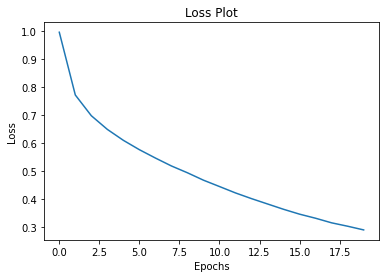

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))
    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start>a cow lying on the beach by the shore <end>
Prediction Caption: people lounging on a beach with an ocean <end>


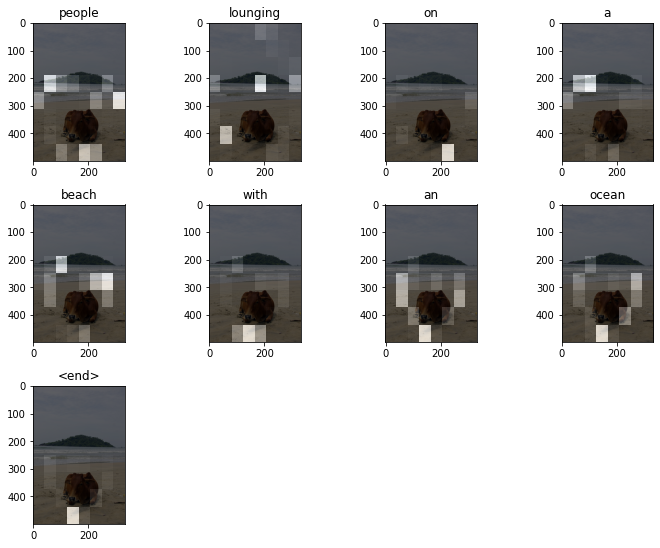

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

65536/64400 [==============================] - 0s 1us/step
Prediction Caption: man in a wet suit riding a wave <end>


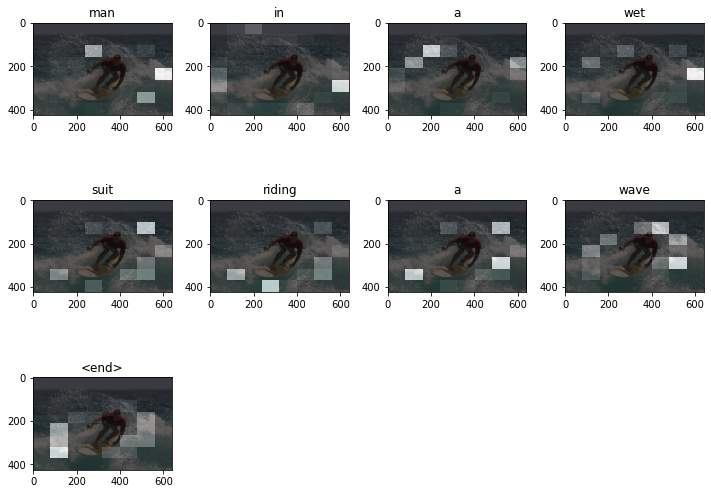

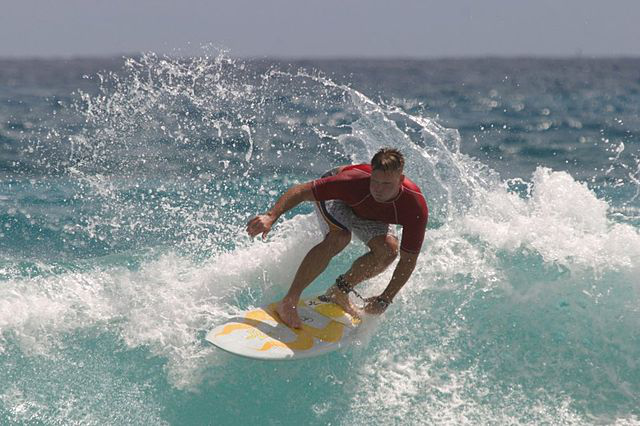

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)